## Binary Classification Data with Dummy Dataset

In this notebook, we'll use **scikit-learn's `make_moons` function** to generate a simple binary classification dataset.

This synthetic dataset consists of two interleaving half-moon shapes and is often used to test nonlinear classification algorithms. We add Gaussian noise to make the task more realistic.

```python
from sklearn.datasets import make_moons

# Create 10,000 samples with some noise
X, y = make_moons(n_samples=10000, noise=0.2, random_state=42)

In [1]:
from sklearn.datasets import make_moons

# Create 10,000 samples with some noise
X, y = make_moons(n_samples=10000, noise=0.2, random_state=42)

## Training a Simple Binary Classifier with PyTorch

In this notebook, we build and train a small neural network to classify a noisy "moons" dataset using PyTorch.

- We use `torch.nn.Sequential` to define a linear layer followed by a sigmoid for binary output.
- The loss function is **Binary Cross-Entropy**, suitable for 2-class problems with a sigmoid output.
- The optimizer is **Stochastic Gradient Descent (SGD)** with **momentum = 0.9** to accelerate training and reduce oscillation.

Momentum helps push the optimizer in a consistent direction by combining past gradients with the current one, making convergence smoother and faster.

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ---------------------------------------
# 1. Split the data and move it to device
# ---------------------------------------
# Assuming X, y already exist from make_moons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train, y_test = y_train.squeeze(), y_test.squeeze()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Convert to PyTorch tensors and move to device
x_train_tensor = torch.as_tensor(X_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device).unsqueeze(1)  # Make shape [N, 1]

# ---------------------------------------
# 2. Define the model
# ---------------------------------------
model = nn.Sequential(
    nn.Linear(2, 4),   # 2 input features → 1 output (binary)
    nn.Linear(4, 1),
    nn.Sigmoid()       # For binary classification
).to(device)


# ---------------------------------------
# 3. Define loss and optimizer with momentum
# ---------------------------------------
criterion = nn.BCELoss()  # Binary cross-entropy loss

# SGD with momentum
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)


# ---------------------------------------
# 4. Train the model
# ---------------------------------------
epochs = 100
loss_vals = []

for epoch in range(epochs):
    model.train()
    
    # Forward pass
    y_pred = model(x_train_tensor)
    
    # Compute loss
    loss = criterion(y_pred, y_train_tensor)
    loss_vals.append(loss.item())

    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f}")

Using device: cuda
Epoch  10 | Loss: 0.5607
Epoch  20 | Loss: 0.4217
Epoch  30 | Loss: 0.3517
Epoch  40 | Loss: 0.3327
Epoch  50 | Loss: 0.3185
Epoch  60 | Loss: 0.3073
Epoch  70 | Loss: 0.2999
Epoch  80 | Loss: 0.2958
Epoch  90 | Loss: 0.2935
Epoch 100 | Loss: 0.2921


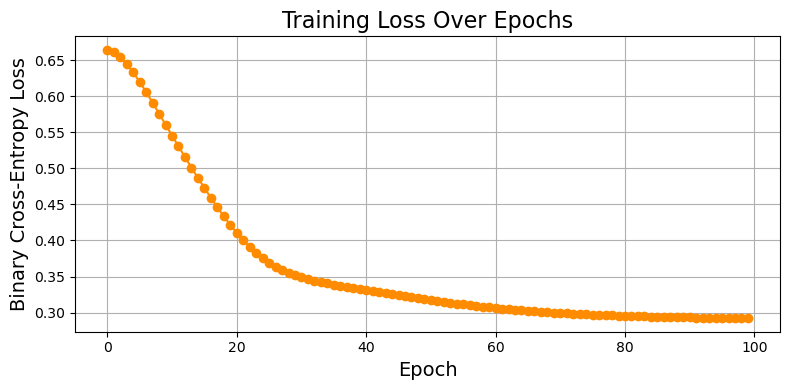

In [25]:
# ---------------------------------------
# 5. Visualize the loss curve
# ---------------------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_vals, 'o-', color='darkorange')
plt.title("Training Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Binary Cross-Entropy Loss", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot the Decison Boundary

In [26]:
import numpy as np
from matplotlib.colors import ListedColormap

# ---------------------------------------
# 1. A method from Lecture 2
# ---------------------------------------
def plot_decision_regions(X, y, model, device='cpu', resolution=0.02, class_names=None):
    """
    Plot decision boundaries for a PyTorch model in a 2D feature space.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, 2)
        Feature matrix with exactly two features.
    y : array-like of shape (n_samples,)
        Target class labels.
    model : torch.nn.Module
        Trained PyTorch model.
    device : str
        'cpu' or 'cuda', where the model and data are located.
    resolution : float
        Step size for the mesh grid.
    class_names : list of str, optional
        Names for each class for the legend.
    """
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Prepare grid for model prediction
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    grid_tensor = torch.from_numpy(grid).float().to(device)

    # Model prediction
    model.eval()
    with torch.no_grad():
        output = model(grid_tensor)
        preds = (output > 0.5).long().cpu().numpy().reshape(xx1.shape)

    # Plot decision surface
    plt.contourf(xx1, xx2, preds, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot class samples
    for idx, cl in enumerate(np.unique(y)):
        label = class_names[idx] if class_names is not None else f"Class {cl}"
        plt.scatter(X[y == cl, 0], X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=label,
                    edgecolor="black")

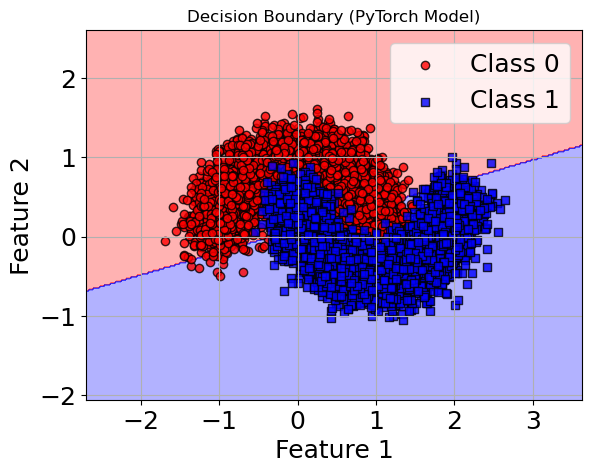

In [27]:
plot_decision_regions(X_train, y_train, model=model, device=device)
plt.title("Decision Boundary (PyTorch Model)")
plt.xlabel("Feature 1", fontsize=18)
plt.ylabel("Feature 2", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

## Confusion Matrix and the ROC Curve

In [30]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Force CPU to avoid CUDA issues
device = 'cpu'

# Predict on test set
model.eval()
with torch.no_grad():
    x_test_tensor = torch.as_tensor(X_test).float().to(device)
    y_test_tensor = torch.as_tensor(y_test).float().to(device).unsqueeze(1)
    
    y_prob = model(x_test_tensor).cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)

# Normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix plot
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'],
            ax=ax1)
ax1.set_title("Normalized Confusion Matrix", fontsize=18)
ax1.set_xlabel("Predicted", fontsize=16)
ax1.set_ylabel("Actual", fontsize=16)
ax1.tick_params(labelsize=14)

# ROC curve plot
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_title("ROC Curve", fontsize=18)
ax2.set_xlabel("False Positive Rate", fontsize=16)
ax2.set_ylabel("True Positive Rate", fontsize=16)
ax2.legend(loc="lower right", fontsize=14)
ax2.grid(True)
ax2.tick_params(labelsize=14)

plt.tight_layout()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)